### Importing Libraries

In [1]:
import os, re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import scipy.spatial

### Processing and Compiling 

In [2]:
def minor_preprocess(file):

  with open(file, 'rb') as f:
    lines = f.readlines()
    utf8_safe_lines = [line.decode('utf-8', 'ignore') for line in lines]
    xml_safe_lines = [re.sub(r'&#\d*;', '', line) for line in utf8_safe_lines]
    no_newlines = [line.replace('\n', ' ') for line in xml_safe_lines]
  f.close()

  return ''.join(no_newlines)


In [3]:
def compile_data(datapath='data'):
  dataset = []
  for file in os.listdir(datapath):
    if file.endswith('.sgm'):
      preprocessed_data = minor_preprocess(datapath + '/' + file)
      records = [record + '</REUTERS>' for record in preprocessed_data.split('</REUTERS>') if record]
      dataset.extend(records)
  
  return dataset

In [4]:
def compile_dictionary(data):
  
  data_dict = {
    #  'Title': '',
      'Body': '', 
      'Country': '',
      }
    
  soup = BeautifulSoup(data, 'xml')

  try:
   # if soup.TITLE.contents:
    #  body = soup.TITLE.contents[0]
    #  data_dict['Title'] = soup.TITLE.contents[0]
        
    if soup.BODY.contents:
      body = soup.BODY.contents[0]
      data_dict['Body'] = soup.BODY.contents[0]
        
    if soup.PLACES.contents:
      body = soup.PLACES.contents[0]
      data_dict['Country'] = soup.PLACES.D.contents[0]
    
  except AttributeError:
    pass

  return data_dict


In [5]:
dataset = compile_data()

In [6]:
dataset_dicts = [compile_dictionary(data) for data in dataset]

### About the Data

In [7]:
dataset_dicts = [data for data in dataset_dicts]

In [8]:
df = pd.DataFrame(dataset_dicts)

In [9]:
df

,Body,Country
0,Inco Ltd said it did not expect its earlier re...,canada
1,"Mason Benson, former president and chief opera...",usa
2,In a discovery that could complicate the searc...,usa
3,Doctors at the Centers for Disease Control in ...,usa
4,U.S. economic data this week could be the key ...,usa
...,...,...
21595,The Soviet Union's industrial output is growin...,ussr
21596,Six black miners have been killed and two inju...,south-africa
21597,The prospect of a dominant alliance of sociali...,switzerland
21598,The American Stock Exchange said it has introd...,usa


In [10]:
df.columns

Index(['Body', 'Country'], dtype='object')

In [11]:
df.Country.value_counts()

usa                    11759
                        3202
uk                      1238
canada                   882
japan                    697
                       ...  
aruba                      1
iceland                    1
zaire                      1
mozambique                 1
yemen-demo-republic        1
Name: Country, Length: 115, dtype: int64

In [12]:
df_clean = df.loc[df['Country'].isin(['usa', 'canada', 'west-germany', 'france', 'uk', 'japan'])]

In [13]:
df_clean

,Body,Country
0,Inco Ltd said it did not expect its earlier re...,canada
1,"Mason Benson, former president and chief opera...",usa
2,In a discovery that could complicate the searc...,usa
3,Doctors at the Centers for Disease Control in ...,usa
4,U.S. economic data this week could be the key ...,usa
...,...,...
21583,Iranian President Ali Khamenei said he doubted...,usa
21586,The Ministry of Finance has started to conside...,japan
21592,An announcement by Alliant Computer Systems In...,usa
21593,Tokyo's foreign exchange market is watching ne...,japan


###  Train/Test 60/40

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_clean ['Body'], df_clean ['Country'], test_size = 0.4)

###  Train/Test 30/70


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_clean ['Body'], df_clean ['Country'], test_size = 0.7)

###  Train/Test 50/50


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_clean ['Body'], df_clean ['Country'], test_size = 0.5)

In [17]:
X_train.shape

(7647,)

###  Training & Testing KNN


In [18]:
print('Training & Testing KNN euclidean metric')
print('Iterations - ', end='')

euc_acc_knn, euc_prec_knn, euc_rec_knn = [], [], []
index = []
maxn, steps = 10, 1

i = steps
while i <= maxn:
    print(i, end='')
    index.append(i)

    model_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=i, metric='euclidean'))])

    model_knn.fit(X_train, y_train)    

    y_pred = model_knn.predict(X_test)

    euc_acc_knn.append(metrics.accuracy_score(y_test, y_pred))
    euc_prec_knn.append(metrics.precision_score(y_test, y_pred, average='weighted'))
    euc_rec_knn.append(metrics.recall_score(y_test, y_pred, average='weighted'))

    i += steps

    del model_knn
    del y_pred

Training & Testing KNN euclidean metric
Iterations - 1

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


2

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


4

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


5

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


6

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


7

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


8

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


9

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


10

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [19]:
print('Creating Result DataFrame', end=' ')
columns=['Accuracy', 'Precision', 'Recall']
euc_df_knn = pd.DataFrame(columns=columns, index=index)

euc_df_knn['Accuracy'] = euc_acc_knn
euc_df_knn['Precision'] = euc_prec_knn
euc_df_knn['Recall'] = euc_rec_knn

print(' - Done')

print()
print('Accuracy')
i = steps
while i<=maxn:
    print(i, euc_df_knn['Accuracy'][i])
    i += steps

print()
print('Precision')
i = steps
while i<=maxn:
    print(i, euc_df_knn['Precision'][i])
    i += steps

print()    
print('Recall')
i = steps
while i<=maxn:
    print(i, euc_df_knn['Recall'][i])
    i += steps

Creating Result DataFrame  - Done

Accuracy
1 0.8832374476987448
2 0.8500261506276151
3 0.8902981171548117
4 0.8893828451882845
5 0.8923901673640168
6 0.8930439330543933
7 0.8934361924686193
8 0.8923901673640168
9 0.8892520920502092
10 0.8892520920502092

Precision
1 0.8814441179208826
2 0.874927580439772
3 0.8843847399274831
4 0.883813061921262
5 0.8859575049743099
6 0.8867616444377152
7 0.8876585597622669
8 0.8872242940070274
9 0.8844572650095462
10 0.8849002915400888

Recall
1 0.8832374476987448
2 0.8500261506276151
3 0.8902981171548117
4 0.8893828451882845
5 0.8923901673640168
6 0.8930439330543933
7 0.8934361924686193
8 0.8923901673640168
9 0.8892520920502092
10 0.8892520920502092


Extracted Data Shape 
Train :  (7647,)
Test  :  (7648,)



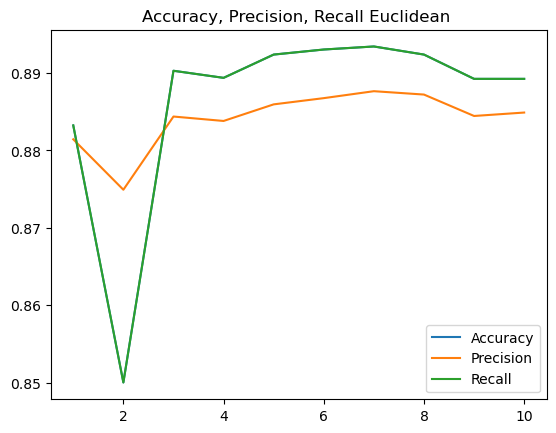

In [20]:
print('Extracted Data Shape ')
print('Train : ', X_train.shape)
print('Test  : ', X_test.shape)
print()
plt.plot(index, euc_acc_knn, label='Accuracy')
plt.plot(index, euc_prec_knn, label='Precision')
plt.plot(index, euc_rec_knn, label='Recall')
plt.legend(loc=4)
plt.title('Accuracy, Precision, Recall Euclidean ')
plt.show()

In [21]:
print('Training & Testing KNN chebyshev metric')
print('Iterations - ', end='')

cheb_acc_knn, cheb_prec_knn, cheb_rec_knn = [], [], []
index = []
maxn, steps = 10, 1

i = steps
while i <= maxn:
    print(i, end='')
    index.append(i)

    model_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=i))])

    model_knn.fit(X_train, y_train)    

    y_pred = model_knn.predict(X_test)

    cheb_acc_knn.append(metrics.accuracy_score(y_test, y_pred))
    cheb_prec_knn.append(metrics.precision_score(y_test, y_pred, average='weighted'))
    cheb_rec_knn.append(metrics.recall_score(y_test, y_pred, average='weighted'))

    i += steps

    del model_knn
    del y_pred

Training & Testing KNN chebyshev metric
Iterations - 1

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


2

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


4

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


5

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


6

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


7

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


8

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


9

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


10

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [22]:
print('Creating Result DataFrame', end=' ')
columns=['Accuracy', 'Precision', 'Recall']
cheb_df_knn = pd.DataFrame(columns=columns, index=index)

cheb_df_knn['Accuracy'] = cheb_acc_knn
cheb_df_knn['Precision'] = cheb_prec_knn
cheb_df_knn['Recall'] = cheb_rec_knn

print(' - Done')

print()
print('Accuracy')
i = steps
while i<=maxn:
    print(i, cheb_df_knn['Accuracy'][i])
    i += steps

print()
print('Precision')
i = steps
while i<=maxn:
    print(i, cheb_df_knn['Precision'][i])
    i += steps

print()    
print('Recall')
i = steps
while i<=maxn:
    print(i, cheb_df_knn['Recall'][i])
    i += steps

Creating Result DataFrame  - Done

Accuracy
1 0.8832374476987448
2 0.8500261506276151
3 0.8902981171548117
4 0.8893828451882845
5 0.8923901673640168
6 0.8930439330543933
7 0.8934361924686193
8 0.8923901673640168
9 0.8892520920502092
10 0.8892520920502092

Precision
1 0.8814441179208826
2 0.874927580439772
3 0.8843847399274831
4 0.883813061921262
5 0.8859575049743099
6 0.8867616444377152
7 0.8876585597622669
8 0.8872242940070274
9 0.8844572650095462
10 0.8849002915400888

Recall
1 0.8832374476987448
2 0.8500261506276151
3 0.8902981171548117
4 0.8893828451882845
5 0.8923901673640168
6 0.8930439330543933
7 0.8934361924686193
8 0.8923901673640168
9 0.8892520920502092
10 0.8892520920502092


Extracted Data Shape 
Train :  (7647,)
Test  :  (7648,)



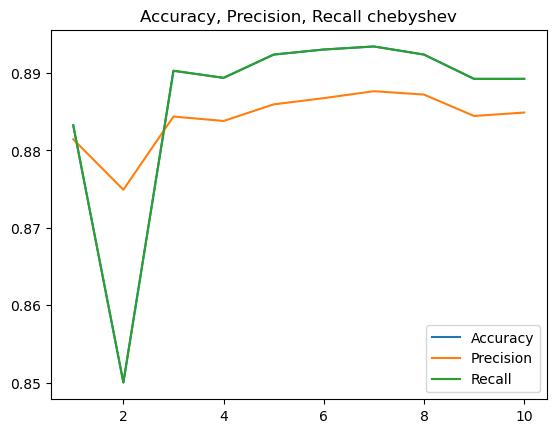

In [23]:
print('Extracted Data Shape ')
print('Train : ', X_train.shape)
print('Test  : ', X_test.shape)
print()
plt.plot(index, cheb_acc_knn, label='Accuracy')
plt.plot(index, cheb_prec_knn, label='Precision')
plt.plot(index, cheb_rec_knn, label='Recall')
plt.legend(loc=4)
plt.title('Accuracy, Precision, Recall chebyshev')
plt.show()

In [24]:
print('Training & Testing KNN cityblock metric')
print('Iterations - ', end='')

city_acc_knn, city_prec_knn, city_rec_knn = [], [], []
index = []
maxn, steps = 10, 1

i = steps
while i <= maxn:
    print(i, end='')
    index.append(i)

    model_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=i, metric='cityblock'))])

    model_knn.fit(X_train, y_train)    

    y_pred = model_knn.predict(X_test)

    city_acc_knn.append(metrics.accuracy_score(y_test, y_pred))
    city_prec_knn.append(metrics.precision_score(y_test, y_pred, average='weighted'))
    city_rec_knn.append(metrics.recall_score(y_test, y_pred, average='weighted'))

    i += steps

    del model_knn
    del y_pred

Training & Testing KNN cityblock metric
Iterations - 1

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


2

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


4

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


5

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


6

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


7

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


8

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


9

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


10

/Users/whitez0r/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [25]:
print('Creating Result DataFrame', end=' ')
columns=['Accuracy', 'Precision', 'Recall']
city_df_knn = pd.DataFrame(columns=columns, index=index)

city_df_knn['Accuracy'] = city_acc_knn
city_df_knn['Precision'] = city_prec_knn
city_df_knn['Recall'] = city_rec_knn

print(' - Done')

print()
print('Accuracy')
i = steps
while i<=maxn:
    print(i, city_df_knn['Accuracy'][i])
    i += steps

print()
print('Precision')
i = steps
while i<=maxn:
    print(i, city_df_knn['Precision'][i])
    i += steps

print()    
print('Recall')
i = steps
while i<=maxn:
    print(i, city_df_knn['Recall'][i])
    i += steps

Creating Result DataFrame  - Done

Accuracy
1 0.8314592050209205
2 0.8038702928870293
3 0.8121077405857741
4 0.8067468619246861
5 0.8089696652719666
6 0.8028242677824268
7 0.8021705020920502
8 0.8006014644351465
9 0.8021705020920502
10 0.7992939330543933

Precision
1 0.8276227835057477
2 0.8243776719850812
3 0.8048177314619611
4 0.8065759009692313
5 0.8009091067728737
6 0.7991625645298694
7 0.7911497888554055
8 0.7882929918003841
9 0.7884300507731092
10 0.7877846536654214

Recall
1 0.8314592050209205
2 0.8038702928870293
3 0.8121077405857741
4 0.8067468619246861
5 0.8089696652719666
6 0.8028242677824268
7 0.8021705020920502
8 0.8006014644351465
9 0.8021705020920502
10 0.7992939330543933


Extracted Data Shape 
Train :  (7647,)
Test  :  (7648,)



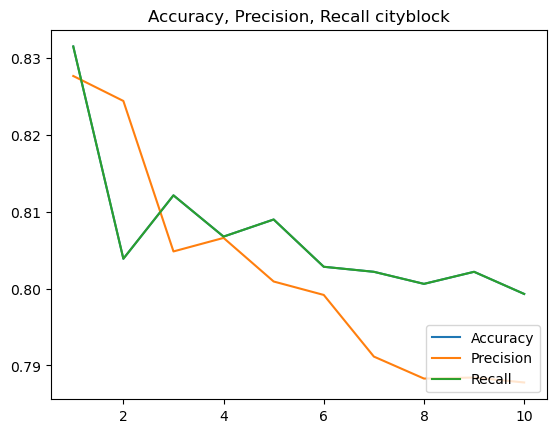

In [26]:
print('Extracted Data Shape ')
print('Train : ', X_train.shape)
print('Test  : ', X_test.shape)
print()
plt.plot(index, city_acc_knn, label='Accuracy')
plt.plot(index, city_prec_knn, label='Precision')
plt.plot(index, city_rec_knn, label='Recall')
plt.legend(loc=4)
plt.title('Accuracy, Precision, Recall cityblock')
plt.show()